In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

C:\Users\320026907\AppData\Local\conda\conda\envs\amar\lib\site-packages\dicom\__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [2]:
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import cv2

In [3]:
# Some constants 
INPUT_FOLDER = './S13408'

In [4]:
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)] #Read all slices of 3D dicom image
    slices.sort(key = lambda x: int(x.InstanceNumber))
    return slices

In [5]:
patient = load_scan(INPUT_FOLDER)

In [6]:
patient_img_data = []
for i in range(len(patient)):
    patient_img_data.append(patient[i].pixel_array)

In [7]:
patient_data = np.array(patient_img_data)

In [8]:
#Dicom tag "Samples per Pixel" specifies no of channels in dicom pixel data
#1 for the single grayscale channel and 3 for RGB

#"Photometric Interpratation" = "RGB" ---- For Red, Green, Blue
#                             = ""MONOCHROME2" ---- meaning its grayscale and 0 should be interpreted as Black
patient_data.shape

(166, 256, 256)

In [35]:
'''maxi = -1
img_no = -1
for i in range(len(patient_data)):
    if maxi < np.max(patient_data[i]):
        maxi = np.max(patient_data[i])
        img_no = i
''' 

In [36]:
#print(maxi,img_no)

16898 102


In [9]:
print("Max pixel data = ",np.max(patient_data))
print("Min pixel data = ",np.min(patient_data))

Max pixel data =  17004
Min pixel data =  0


In [ ]:
'''img = cv2.threshold(patient_data,100,255,cv2.THRESH_BINARY)
cv2.imshow('image',img)
cv2.waitKey(0)
cv2.destroyAllWindows()'''

In [11]:
def Normalize_image(patient_data):
    Max_pixel = np.max(patient_data)
    Min_pixel = np.min(patient_data)
    new_img = (patient_data-Min_pixel)/(Max_pixel-Min_pixel)
    return new_img
    

In [12]:
new_img = Normalize_image(patient_data)

In [13]:
new_img.shape

(166, 256, 256)

In [16]:
np.min(new_img)

0.0

In [21]:
print("Mean of Normalized image = ",np.mean(new_img))
print("Mean of original image = ",np.mean(patient_data))
print("SD of Normalized image = ",np.std(new_img))
print("SD of original image = ",np.std(patient_data))

Mean of Normalized image =  0.07202060303854815
Mean of original image =  1224.638334067471
SD of Normalized image =  0.09952202374032751
SD of original image =  1692.2724916805287


In [29]:
def standardize_image(patient_data):
    std_img = (patient_data - np.mean(patient_data))/np.std(patient_data)
    return std_img

In [30]:
std_img = standardize_image(patient_data)

In [38]:
print("Mean of Standardized image = ",np.mean(std_img))
print("Mean of original image = ",np.mean(patient_data))
print("SD of Standardized image = ",np.std(std_img))
print("SD of original image = ",np.std(patient_data))

Mean of Standardized image =  6.077802250771753e-17
Mean of original image =  1224.638334067471
SD of Standardized image =  1.0000000000000002
SD of original image =  1692.2724916805287


In [39]:
'''Normalization rescales the values into a range of [0,1]. 
This might be useful in some cases where all parameters need to have the same positive scale. 
However, the outliers from the data set are lost. 
Standardization rescales data to have a mean ( ) of 0 and standard deviation ( ) of 1 (unit variance).'''

#Normalization and Standardization helps to converge the GD fast

'''NormaliZation:
Normalization is useful when your data has varying scales and the algorithm you are using does not make assumptions about the 
distribution of your data, such as k-nearest neighbors and artificial neural networks.

You can use other scales such as -1 to 1, which is useful when using support vector machines and adaboost.
'''

'''
Standardization:
Standardization is useful when your data has varying scales and the algorithm you are using does make assumptions about 
your data having a Gaussian distribution, such as linear regression, logistic regression and linear discriminant analysis.
'''

'Normalization rescales the values into a range of [0,1]. \nThis might be useful in some cases where all parameters need to have the same positive scale. \nHowever, the outliers from the data set are lost. \nStandardization rescales data to have a mean ( ) of 0 and standard deviation ( ) of 1 (unit variance).'

In [ ]:
'''
Resampling in image:
Image resampling is the process of transforming a sampled image from one coordinate system to another.'''

'''
Resampling means you're changing the pixel dimensions of an image. 
When you downsample, you're eliminating pixels and therefore deleting information and detail from your image. 
When you upsample, you're adding pixels. Photoshop adds these pixels by using interpolation.'''

In [76]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = np.array(list(spacing))
    #print("[Slice Thickness, pixel Width, Height] = ",spacing)
    resize_factor = spacing / new_spacing
    #print("resize_factor = ", resize_factor)
    new_real_shape = image.shape * resize_factor
    #print("new_real_shape = ", new_real_shape)
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    #print("real_resize_factor = ", real_resize_factor)
    new_spacing = spacing / real_resize_factor
    #print("new_spacing = ", new_spacing)
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

In [78]:
pix_resampled, spacing = resample(patient_data, patient, [1,1,1])

[Slice Thickness, pixel Width, Height] =  [1.2    0.9375 0.9375]
resize_factor =  [1.2    0.9375 0.9375]
new_real_shape =  [199.2 240.  240. ]
real_resize_factor =  [1.19879518 0.9375     0.9375    ]
new_spacing =  [1.00100503 1.         1.        ]


In [79]:
print("Shape before resampling\t", patient_data.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (166, 256, 256)
Shape after resampling	 (199, 240, 240)


In [47]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    #verts, faces = measure.marching_cubes(p, threshold)
    verts, faces, normals, values = measure.marching_cubes_lewiner(p, threshold)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [50]:
#To plot the 3D image
plot_3d(pix_resampled, 200)

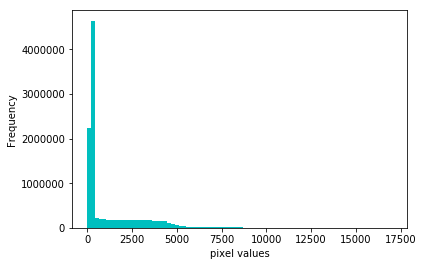

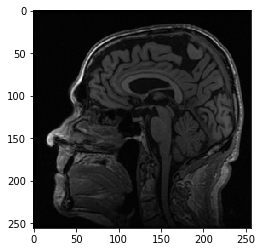

In [97]:
#pixel value frequencies
plt.hist(patient_data.flatten(), bins=80, color='c')
plt.xlabel("pixel values")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(patient_data[80], cmap=plt.cm.gray)
plt.show()

255
84.0
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


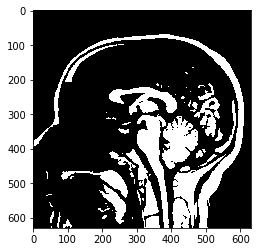

In [120]:
# Otsu's thresholding after Gaussian filtering
print(np.max(img))
blur = cv2.GaussianBlur(img,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

print(ret3)
print(th3)
# Show some slice in the middle
plt.imshow(th3, cmap=plt.cm.gray)
plt.show()

In [105]:
img = cv2.imread('test.jpeg',0)
print(img)

[[16 16 16 ... 16 16 16]
 [16 16 16 ... 16 16 16]
 [16 16 16 ... 16 16 16]
 ...
 [17 17 17 ... 16 16 16]
 [16 16 16 ... 16 16 16]
 [15 15 15 ... 16 16 17]]


In [116]:
print(patient_data[80])

[[  0   0   0 ...  41  62  46]
 [  0   0   0 ...  78  65  77]
 [ 67  51  62 ... 115  77 101]
 ...
 [ 88 173 167 ... 197 175 134]
 [ 69 112  91 ... 128 155 135]
 [ 60  99  83 ...  59  88  78]]


In [126]:
#NewValue = (((OldValue - OldMin) * (NewMax - NewMin)) / (OldMax - OldMin)) + NewMin
new = (((1-0)*(255-0))/(1514-0)) + 0
print(new)

0.16842800528401586


In [127]:
def Normalize_0_to_255(img):
    OldMin = np.min(img)
    OldMax = np.max(img)
    
    NewMin = 0
    NewMax = 255
    
    new_img = (((img - OldMin) * (NewMax - NewMin)) / (OldMax - OldMin)) + NewMin
    return new_img

In [128]:
new_img = Normalize_0_to_255(patient_data[80])

In [129]:
print(new_img)

[[ 0.          0.          0.         ...  0.67621758  1.02257293
   0.75868314]
 [ 0.          0.          0.         ...  1.28646271  1.07205226
   1.2699696 ]
 [ 1.10503848  0.8411487   1.02257293 ...  1.89670785  1.2699696
   1.66580428]
 ...
 [ 1.45139383 -1.38548606 -1.48444473 ... -0.98965138 -1.35249984
  -2.02871742]
 [ 1.13802471  1.84722851  1.50087316 ...  2.1111183  -1.68236207
  -2.01222431]
 [ 0.9895867   1.63281806  1.36892827 ...  0.97309359  1.45139383
   1.28646271]]


1100.0
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


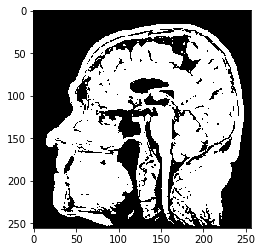

In [181]:
# Otsu's thresholding after Gaussian filtering
#print(np.max(img))
#blur = cv2.GaussianBlur(patient_data[80],(5,5),0)
#blur = blur.astype('uint8')
#ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#ret3,th3 = cv2.threshold(img,0,255,cv2.THRESH_OTSU)
#th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
#th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,9,1.5)
ret3,th3 = cv2.threshold(patient_data[80],1100,255,cv2.THRESH_BINARY)
print(ret3)
print(th3)
# Show some slice in the middle
#plt.imshow(patient_data[80], cmap=plt.cm.gray)
plt.imshow(th3, cmap=plt.cm.gray)

In [ ]:
#In this, the algorithm calculate the threshold for a small regions of the image.  So we get different thresholds 
#for different regions of the same image and it gives us better results for images with varying illumination.
'''
Adaptive Method - It decides how thresholding value is calculated.

cv2.ADAPTIVE_THRESH_MEAN_C : threshold value is the mean of neighbourhood area.
cv2.ADAPTIVE_THRESH_GAUSSIAN_C : threshold value is the weighted sum of neighbourhood values where weights are a gaussian window.
'''
'''
Block Size - It decides the size of neighbourhood area.

C - It is just a constant which is subtracted from the mean or weighted mean calculated.
'''


#Thresholding operation is used to convert a multilevel/gray scale image into binary image 
#The advantage of obtaining first a binary image is that it reduces the complexity of the data 
#and simplifies the process of recognition and classifiction.
